In [1]:
from typing import *

import matplotlib.pyplot as plt
import torch

from tqdm import tqdm
from xai.genome import Genome
from xai.bytes import GigaBytes
from xai.policy import Policy
from xai.asteroids import Asteroids
from xai.stream import Stream

In [ ]:
genome = Genome(translate=True, rotate=True, volatility=1.0)

population = genome.populate(
    population_size=50,
    max_memory=GigaBytes(5.0),
    verbose=True
)

In [ ]:
population.evolve(
    generations=10,
    survivors_cnt=1,
    elites_cnt=0,
    roulettes_cnt=0,
    random_cnt=0,
    rank_cnt=10,
    checkpoints_directory="Test",
    number_of_processes=4
)

In [ ]:
population._observations.enumerate().save(lambda obs: f"dataset/test/obs{obs[0]}")

In [184]:
from xai.observation import Observation

X = Stream(range(60_000)).load(lambda i: (Tuple[int,Observation], f"dataset/test/obs{i}"), raise_error=False)\
    .map(lambda t: t[1].tensor(normalize=True, device="cpu"))\
    .map(lambda t: t.movedim(2,0))\
    .buffer(eviction_policy="Random", use_ram=False)

X

Buffer(use_ram=False, entries=49510, size=19982.68MB)

In [185]:
f = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3,  out_channels=8,     kernel_size=(3,3), stride=(1,1)),
    torch.nn.Conv2d(in_channels=8,  out_channels=16,    kernel_size=(5,5), stride=(2,2)),
    torch.nn.Conv2d(in_channels=16, out_channels=32,    kernel_size=(7,7), stride=(3,3)),
    torch.nn.Conv2d(in_channels=32, out_channels=64,    kernel_size=(9,9), stride=(4,4)),
    torch.nn.Flatten(),

    torch.nn.Linear(in_features=64*6*4, out_features=32*6*4),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=32*6*4, out_features=16*6*4),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=16*6*4, out_features=8*6*4),

    torch.nn.Linear(in_features=8*6*4, out_features=16*6*4),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=16*6*4, out_features=32*6*4),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=32*6*4, out_features=64*6*4),

    torch.nn.Unflatten(dim=1, unflattened_size=(64,6,4)),
    torch.nn.ConvTranspose2d(in_channels=64,    out_channels=32,    kernel_size=(9,9), stride=(4,4), output_padding=(3,3)),
    torch.nn.ConvTranspose2d(in_channels=32,    out_channels=16,    kernel_size=(7,7), stride=(3,3), output_padding=(2,1)),
    torch.nn.ConvTranspose2d(in_channels=16,    out_channels=8,     kernel_size=(5,5), stride=(2,2), output_padding=(1,1)),
    torch.nn.ConvTranspose2d(in_channels=8,     out_channels=3,     kernel_size=(3,3), stride=(1,1)),
)

In [2]:
f = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=3,  out_channels=8,     kernel_size=(3,3), stride=(1,1)),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=8,  out_channels=16,    kernel_size=(5,5), stride=(2,2)),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=16, out_channels=32,    kernel_size=(7,7), stride=(3,3)),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=32, out_channels=64,    kernel_size=(9,9), stride=(4,4)),
    torch.nn.ReLU(),
    torch.nn.Flatten(),

    torch.nn.Linear(in_features=64*6*4, out_features=32*6*4),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=32*6*4, out_features=16*6*4),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=16*6*4, out_features=8*6*4),

    torch.nn.Linear(in_features=8*6*4, out_features=16*6*4),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=16*6*4, out_features=32*6*4),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=32*6*4, out_features=64*6*4),
    torch.nn.ReLU(),

    torch.nn.Unflatten(dim=1, unflattened_size=(64,6,4)),
    torch.nn.ConvTranspose2d(in_channels=64,    out_channels=32,    kernel_size=(9,9), stride=(4,4), output_padding=(3,3)),
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(in_channels=32,    out_channels=16,    kernel_size=(7,7), stride=(3,3), output_padding=(2,1)),
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(in_channels=16,    out_channels=8,     kernel_size=(5,5), stride=(2,2), output_padding=(1,1)),
    torch.nn.ReLU(),
    torch.nn.ConvTranspose2d(in_channels=8,     out_channels=3,     kernel_size=(3,3), stride=(1,1)),
).cuda()

In [174]:
torch.unsqueeze

torch.Size([1, 3, 2, 2])

In [186]:
adam = torch.optim.Adam(f.parameters())

def mini_batch(size: int):
    return torch.stack(X.randoms(with_replacement=True).take(size).tuple())

with tqdm(total=5000) as bar:
    for epoch in range(1000):
        adam.zero_grad()
        x = mini_batch(64)
        y_hat = f(x)
        loss = ((x - y_hat)**2).mean()
        loss.backward()
        adam.step()
        bar.set_description(f"Loss: {float(loss.item()):.4f}")
        bar.update()

  0%|          | 0/5000 [00:00<?, ?it/s]

Loss: 0.0093:   4%|▎         | 185/5000 [01:59<51:39,  1.55it/s]  


KeyboardInterrupt: 

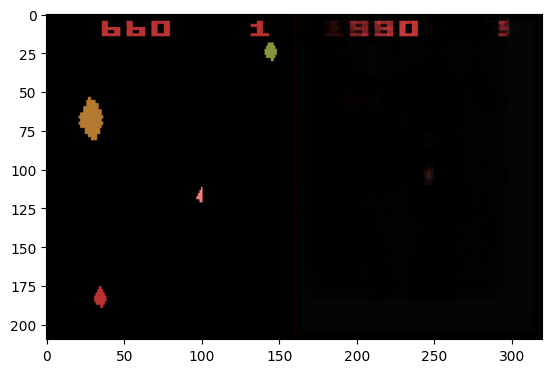

In [202]:
idx = 4992
x = X[idx].tuple()[0]
with torch.no_grad():
    x = x.movedim(0,2)
    y_hat = f(X[idx].tuple()[0].unsqueeze(0))[0].movedim(0,2)

    plt.imshow(torch.hstack([x, y_hat]))

In [ ]:
hidden_dims = [2**8,2**6]
big_encoder = Policy.new(Asteroids.observation_shape, 100, hidden_layers=hidden_dims)
big_decoder = Policy.new(100, Asteroids.observation_shape ,hidden_layers=hidden_dims[::-1])
big_autoencoder = big_encoder + big_decoder
big_autoencoder

In [ ]:
tensor = torch.stack(b.randoms(False).take(3000).map(lambda obs: obs.translated().rotated().tensor(normalize=True, device="cpu")).tuple())


In [ ]:
im = tensor[0].clone()
idy,idx,idc = im.nonzero(as_tuple=True)
im[idy,idx] = torch.tensor([1.0,1.0,0])
plt.imshow(im), 

In [ ]:
from torch import Tensor
import random

def loss(y_hat: Tensor, y: Tensor) -> Tensor:
    n,idy,idx,idc = torch.where(torch.rand((y.shape[0],)) < 0.5, y == 0.0)
    return torch.mean((y_hat[n,idy,idx,idc] - y[n,idy,idx,idc])**2)


big_autoencoder.adam().fit(
    X=tensor,
    Y=tensor,
    epochs=5000,
    batch_size=64,
    loss_criterion=lambda t: t(loss),
    verbose=True
).plot_loss()

In [ ]:
big_autoencoder.predict(tensor[0]).tensor(True).cpu().min()

In [ ]:

idx = 0

X = tensor[idx].cpu()
idy,idx,idc = X.nonzero(as_tuple=True)
Y_hat = big_autoencoder.predict(X).tensor(True).cpu()
Y = torch.zeros_like(Y_hat)
Y[idy,idx] = Y_hat[idy,idx]
print(Y_hat.shape)
plt.imshow(torch.hstack([X, Y_hat,Y]))